In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IPipeline
from xgboost import XGBClassifier
from joblib import parallel_backend
import pickle

In [2]:
train_multi = pd.read_parquet('../data/cleaned/train_multi.parquet')
X_train_multi = train_multi.drop('classification', axis = 1)
y_train_multi = train_multi.classification
test_multi = pd.read_parquet('../data/cleaned/test_multi.parquet')
X_test_multi = test_multi.drop('classification', axis = 1)
y_test_multi = test_multi.classification

In [3]:
train_binary = pd.read_parquet('../data/cleaned/train_binary.parquet')
X_train_binary = train_binary.drop('disposition', axis = 1)
y_train_binary = train_binary.disposition
test_binary = pd.read_parquet('../data/cleaned/test_binary.parquet')
X_test_binary = test_binary.drop('disposition', axis = 1)
y_test_binary = test_binary.disposition

In [4]:
y_train_multi.value_counts()

0    1942
2     814
3     299
1     282
4      71
Name: classification, dtype: int64

In [5]:
y_train_binary.value_counts()

1    2350
0    1942
Name: disposition, dtype: int64

In [6]:
X_train_multi

,ml_fittype,num_of_objects_around_star,right_ascension,declination,g_band_mag,r_band_mag,i_band_mag,z_band_mag,j_band_mag,h_band_mag,...,star_density,abs_gr_diff,abs_gi_diff,abs_gz_diff,abs_ri_diff,abs_rz_diff,abs_iz_diff,abs_jh_diff,abs_jk_diff,abs_hk_diff
3421,LS+MCMC,1,296.88577,40.228230,13.841,13.466,13.354,13.304,12.519,12.263,...,0.91814,0.375,0.487,0.537,0.112,0.162,0.050,0.256,0.311,0.055
1504,LS+MCMC,1,293.14447,46.666241,15.790,15.300,15.188,15.110,14.268,13.967,...,3.37561,0.490,0.602,0.680,0.112,0.190,0.078,0.301,0.365,0.064
1052,LS+MCMC,1,298.39490,40.628910,14.536,14.017,13.861,13.785,12.869,12.558,...,0.97896,0.519,0.675,0.751,0.156,0.232,0.076,0.311,0.333,0.022
8050,LS+MCMC,1,295.61349,46.190689,14.184,13.746,13.617,13.594,12.746,12.501,...,20.19752,0.438,0.567,0.590,0.129,0.152,0.023,0.245,0.342,0.097
2920,LS+MCMC,2,297.27798,48.320332,13.328,12.789,12.642,12.578,11.680,11.399,...,0.73328,0.539,0.686,0.750,0.147,0.211,0.064,0.281,0.360,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,LS+MCMC,1,285.66165,37.964500,13.424,12.843,12.675,12.618,11.672,11.316,...,1.62021,0.581,0.749,0.806,0.168,0.225,0.057,0.356,0.419,0.063
9357,LS+MCMC,1,298.23053,48.794109,13.036,12.703,12.634,12.648,11.771,11.595,...,0.92108,0.333,0.402,0.388,0.069,0.055,0.014,0.176,0.234,0.058
9368,LS+MCMC,1,296.98615,40.675110,14.153,13.744,13.653,13.617,12.711,12.463,...,114.73195,0.409,0.500,0.536,0.091,0.127,0.036,0.248,0.301,0.053
2767,LS+MCMC,1,285.15692,47.873329,16.447,15.654,15.443,15.375,14.390,13.972,...,5.77265,0.793,1.004,1.072,0.211,0.279,0.068,0.418,0.439,0.021


In [7]:
ohe = OneHotEncoder(sparse = False)
transformer = ColumnTransformer([('ohe', ohe, ['ml_fittype'])], remainder = 'passthrough')
X_train_multi_ohe = transformer.fit_transform(X_train_multi)
pd.DataFrame(X_train_multi_ohe, index = X_train_multi.index)

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
3421,0.0,1.0,1.0,296.88577,40.228230,13.841,13.466,13.354,13.304,12.519,...,0.91814,0.375,0.487,0.537,0.112,0.162,0.050,0.256,0.311,0.055
1504,0.0,1.0,1.0,293.14447,46.666241,15.790,15.300,15.188,15.110,14.268,...,3.37561,0.490,0.602,0.680,0.112,0.190,0.078,0.301,0.365,0.064
1052,0.0,1.0,1.0,298.39490,40.628910,14.536,14.017,13.861,13.785,12.869,...,0.97896,0.519,0.675,0.751,0.156,0.232,0.076,0.311,0.333,0.022
8050,0.0,1.0,1.0,295.61349,46.190689,14.184,13.746,13.617,13.594,12.746,...,20.19752,0.438,0.567,0.590,0.129,0.152,0.023,0.245,0.342,0.097
2920,0.0,1.0,2.0,297.27798,48.320332,13.328,12.789,12.642,12.578,11.680,...,0.73328,0.539,0.686,0.750,0.147,0.211,0.064,0.281,0.360,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,0.0,1.0,1.0,285.66165,37.964500,13.424,12.843,12.675,12.618,11.672,...,1.62021,0.581,0.749,0.806,0.168,0.225,0.057,0.356,0.419,0.063
9357,0.0,1.0,1.0,298.23053,48.794109,13.036,12.703,12.634,12.648,11.771,...,0.92108,0.333,0.402,0.388,0.069,0.055,0.014,0.176,0.234,0.058
9368,0.0,1.0,1.0,296.98615,40.675110,14.153,13.744,13.653,13.617,12.711,...,114.73195,0.409,0.500,0.536,0.091,0.127,0.036,0.248,0.301,0.053
2767,0.0,1.0,1.0,285.15692,47.873329,16.447,15.654,15.443,15.375,14.390,...,5.77265,0.793,1.004,1.072,0.211,0.279,0.068,0.418,0.439,0.021


In [8]:
full_column_labels = ['ml_fittype_LS', 'ml_fittype_LS_MCMC'] + X_train_multi.columns.values.tolist()[1:]

In [201]:
samplers = [(SMOTE(random_state = 42, n_jobs = -1)),
            (RandomOverSampler(random_state = 42)),
            None]

In [204]:
def run_model(X_train, X_test, y_train, y_test, estimator = None,
              resampling = None, grid_search = False, grid_params = None, cv = None,
              scoring = None, plot_confusion = True):
    
    numeric_col = X_train.select_dtypes('number').columns.values.tolist()
    object_col = X_train.select_dtypes('object').columns.values.tolist()
    steps_no_resampling = [('ssc', StandardScaler(), numeric_col), ('ohe', OneHotEncoder(), object_col)]
    preprocess_no_resampling = ColumnTransformer(steps_no_resampling)
    
    steps = [('preprocess', preprocess_no_resampling), ('rsm', resampling), ('clf', estimator)]
    pipe = IPipeline(steps = steps)
    
    if grid_search:
        model = GridSearchCV(pipe, param_grid = grid_params, cv = cv, scoring = scoring)
    else:
        model = pipe
    
    with parallel_backend('threading', n_jobs = -1):
        model.fit(X_train, y_train)
    
    if plot_confusion:
        ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test))).plot();
        
    return model

In [96]:
def class_k_recall(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    fn = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        fn += pairs.count((k,i))
    
    return tp / (fn + tp)

In [97]:
def class_k_precision(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    fp = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        fp += pairs.count((i, k))
        
    return tp / (tp + fp)

In [98]:
def class_k_f1(y, y_pred, k = 0):
    recall = class_k_recall(y, y_pred, k)
    precision = class_k_precision(y, y_pred, k)
    
    return 2 * recall * precision / (recall + precision)

In [213]:
def class_k_acc(y, y_pred, k = 0):
    pairs = list(zip(y, y_pred))
    num_of_variables = len(list(set(y)))
    tp = pairs.count((k, k))
    miss = 0
    
    for i in range(num_of_variables):
        if i == k:
            continue
        miss += pairs.count((i, k)) + pairs.count((k, i)) + pairs.count((i,i))
        
    return tp / (tp + miss)

# Binary Class Models

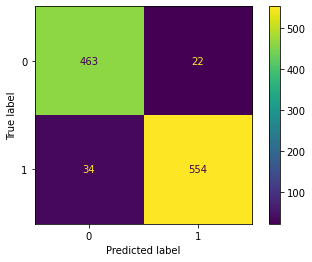

In [99]:
base_logistic_pipe = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                               estimator = LogisticRegression(random_state = 42, max_iter = 1000),
                               plot_confusion = True)

In [100]:
with open('../data/models/binary_base_logistic.pickle', 'wb') as f:
    pickle.dump(base_logistic_pipe, f)

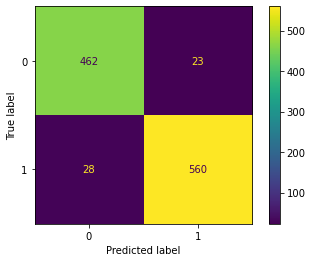

In [102]:
params = [
    {
        'clf': (LogisticRegression(random_state = 42, max_iter = 5000),),
        'clf__C': [1e-4, 1e-3, 1e-2, 1, 1e2, 1e3, 1e4],
    }
]

logistic = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     grid_search = True, grid_params = params, estimator = LogisticRegression(),
                     plot_confusion = True)

In [103]:
with open('../data/models/binary_logistic.pickle', 'wb') as f:
    pickle.dump(logistic, f)

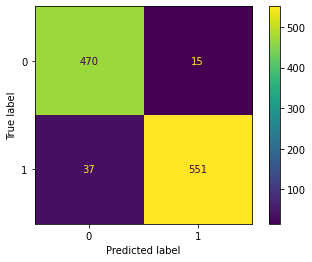

In [107]:
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'clf__max_depth': [5, 7, 9, 11, 13],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', None]
    }
]

tree = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                 grid_search = True, grid_params = params, estimator = DecisionTreeClassifier(),
                 plot_confusion = True)

In [108]:
with open('../data/models/binary_tree.pickle', 'wb') as f:
    pickle.dump(tree, f)

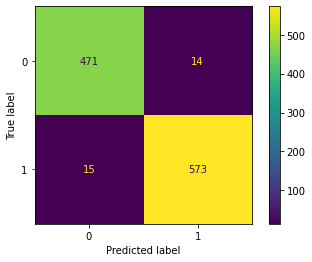

In [111]:
params = [
    {
        'clf': (RandomForestClassifier(random_state = 42),),
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [5, 7, 9]
#         'rsm': samplers
    }
]

random_forest = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                          estimator = RandomForestClassifier(),
                          grid_search = True, grid_params = params, scoring = None,
                          cv = 5, plot_confusion = True)

In [112]:
with open('../data/models/binary_random_forest.pickle', 'wb') as f:
    pickle.dump(random_forest, f)

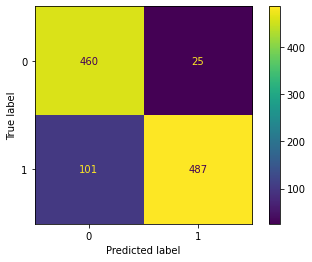

In [94]:
params = [
    {
        'clf': (KNeighborsClassifier(),),
        'clf__n_neighbors': [3, 5, 7, 9, 11, 13],
        'rsm': samplers
    }
]

kneighbors = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                       estimator = KNeighborsClassifier(),
                       grid_search = True, grid_params = params,
                       cv = 5, plot_confusion = True)

In [113]:
with open('../data/models/binary_kneighbors.pickle', 'wb') as f:
    pickle.dump(kneighbors, f)

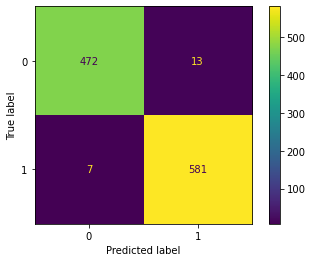

In [72]:
params = [
    {
        'clf': (AdaBoostClassifier(random_state = 42),),
        'clf__base_estimator': [DecisionTreeClassifier(random_state = 42, max_depth = 1),
                           DecisionTreeClassifier(random_state = 42, max_depth = 2)],
        'clf__n_estimators': [100, 200, 300, 400, 500],
        'clf__learning_rate': [0.1, 1],
#         'rsm': samplers
    }
]

adaboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = AdaBoostClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [82]:
with open('../data/models/binary_adaboost.pickle', 'wb') as f:
    pickle.dump(adaboost, f)

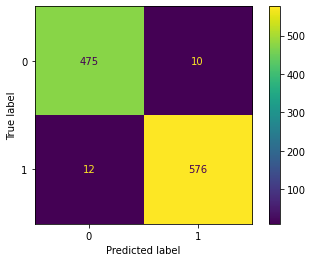

In [81]:
params = [
    {
        'clf': (GradientBoostingClassifier(random_state = 42),),
        'clf__n_estimators': [100, 500, 1000],
        'clf__max_features': [None, 'sqrt'],
        'clf__max_depth': [2, 3]
#         'rsm': samplers
    }
]

gradientboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = GradientBoostingClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [83]:
with open('../data/models/binary_gradientboost.pickle', 'wb') as f:
    pickle.dump(gradientboost, f)

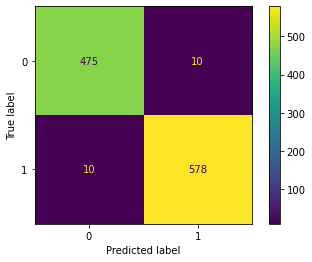

In [91]:
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [100, 500, 1000],
        'clf__max_depth': [6, 9, 12],
#         'rsm': samplers
    }
]

xgboost = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                     estimator = XGBClassifier(), grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [93]:
with open('../data/models/binary_xgboost.pickle', 'wb') as f:
    pickle.dump(xgboost, f)

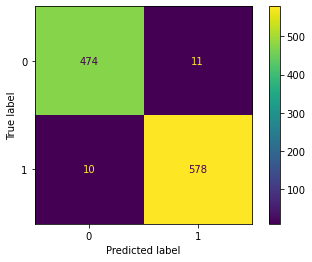

In [256]:
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [1000],
        'clf__max_depth': [9, 12, None],
#         'rsm': samplers
    }
]

xgboost_class_0_recall = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                                   grid_search = True, grid_params = params,
                                   scoring = make_scorer(class_k_recall, k = 0), cv = 5, plot_confusion = True)

In [260]:
with open('../data/models/binary_xgboost_class_0_recall.pickle', 'wb') as f:
    pickle.dump(xgboost_class_0_recall, f)

# Multiclass Models

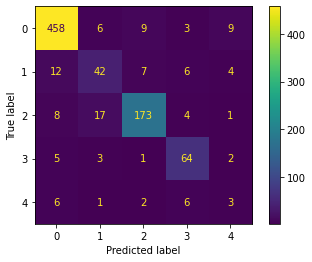

In [120]:
base_decision_tree = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = DecisionTreeClassifier(random_state = 42), plot_confusion = True)

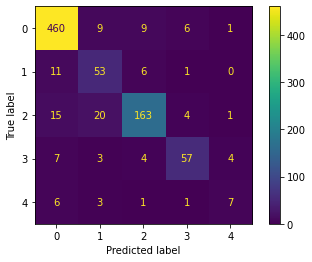

In [137]:
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'rsm': samplers[:-1]
    }
]

base_tree_sampling = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                               estimator = DecisionTreeClassifier(), grid_search = True, grid_params = params,
                               cv = 5, plot_confusion = True)

In [138]:
with open('../data/models/multi_base_tree.pickle', 'wb') as f:
    pickle.dump(base_tree_sampling, f)

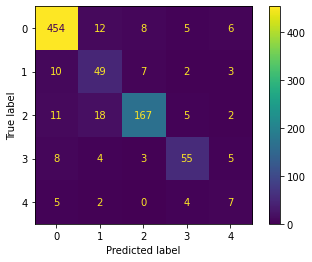

In [134]:
params = [
    {
        'clf': (DecisionTreeClassifier(random_state = 42),),
        'clf__max_depth': [5, 7, 9, 11, 13],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', None],
        'rsm': samplers[:-1]
    }
]

tree = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                 estimator = DecisionTreeClassifier(), grid_search = True, grid_params = params,
                 cv = 5, plot_confusion = True)

In [153]:
with open('../data/models/multi_tree.pickle', 'wb') as f:
    pickle.dump(tree, f)

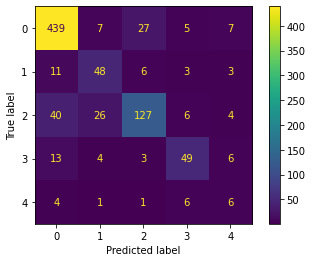

In [160]:
params = [
    {
        'clf': (KNeighborsClassifier(),),
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance'],
        'rsm': samplers[:-1]
    }
]

kneighbors = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                 estimator = KNeighborsClassifier(), grid_search = True, grid_params = params,
                 cv = 5, plot_confusion = True)

In [162]:
with open('../data/models/multi_kneighbors.pickle', 'wb') as f:
    pickle.dump(kneighbors, f)

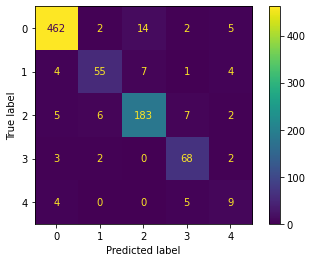

In [169]:
params = [
    {
        'clf': (RandomForestClassifier(random_state = 42),),
        'clf__n_estimators': [100, 300],
        'clf__max_depth': [5, 7, 9],
        'rsm': samplers[:-1]
    }
]

random_forest = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                          estimator = RandomForestClassifier(),
                          grid_search = True, grid_params = params, scoring = None,
                          cv = 5, plot_confusion = True)

In [171]:
with open('../data/models/multi_random_forest.pickle', 'wb') as f:
    pickle.dump(random_forest, f)

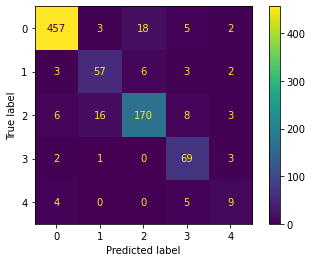

In [172]:
params = [
    {
        'clf': (AdaBoostClassifier(random_state = 42),),
        'clf__base_estimator': [DecisionTreeClassifier(random_state = 42, max_depth = 1),
                                DecisionTreeClassifier(random_state = 42, max_depth = 2),
                                DecisionTreeClassifier(random_state = 42, max_depth = 3)],
        'clf__n_estimators': [100, 300, 500],
        'rsm': samplers[:-1]
    }
]

adaboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = AdaBoostClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [176]:
with open('../data/models/multi_adaboost.pickle', 'wb') as f:
    pickle.dump(adaboost, f)

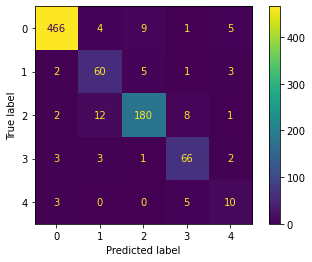

In [179]:
params = [
    {
        'clf': (GradientBoostingClassifier(random_state = 42),),
#         'clf__n_estimators': [100, 500],
        'clf__max_features': [None, 'sqrt'],
        'clf__max_depth': [2, 3],
        'rsm': samplers[:-1]
    }
]

gradientboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = GradientBoostingClassifier(),
                     grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [180]:
with open('../data/models/multi_gradientboost.pickle', 'wb') as f:
    pickle.dump(gradientboost, f)

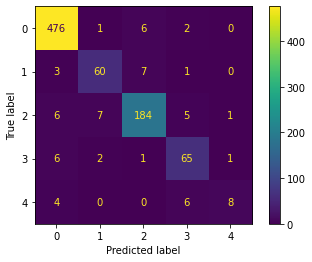

In [187]:
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [1000],
        'clf__max_depth': [6, 12],
        'clf__colsample_bynode': [0.5, 1],
        'rsm': samplers[:-1]
    }
]

xgboost = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     estimator = XGBClassifier(), grid_search = True, grid_params = params,
                     cv = 5, plot_confusion = True)

In [190]:
with open('../data/models/multi_xgboost.pickle', 'wb') as f:
    pickle.dump(xgboost, f)

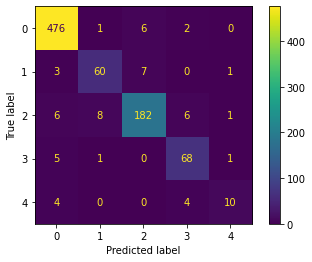

In [237]:
params = [
    {
        'clf': (XGBClassifier(random_state = 42),),
        'clf__n_estimators': [500],
        'clf__max_depth': [3, 6],
        'clf__colsample_bynode': [0.25, 0.5],
        'rsm': [samplers[-2]]
    }
]

xgboost_class_0_recall = run_model(X_train_multi, X_test_multi, y_train_multi, y_test_multi,
                     grid_search = True, grid_params = params, scoring = make_scorer(class_k_recall, k = 0),
                     cv = 3, plot_confusion = True)

In [248]:
with open('../data/models/multi_xgboost_class_0_recall.pickle', 'wb') as f:
    pickle.dump(xgboost_class_0_recall, f)